In [1]:
import os, sys
from os.path import exists as file_exists
import numpy as np
import emcee
import zeus
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyu
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
from chainconsumer import ChainConsumer
import time
import h5py

In [2]:
#Load data from file, check if the data file is in the same directory of the code.

data_file = "HzTable_2020.dat"
z, Hz, errHz = np.genfromtxt(data_file, comments='#', usecols=(0,1,2), unpack=True, delimiter=',')
ref = np.genfromtxt(data_file, comments='#', usecols=(3), unpack=True, dtype=str, delimiter=',')

In [3]:
#Number of parameters to estimate
ndim = 5

#True values

#Planck
H0_pl = 67.37 
errH0_pl = 0.54
Omegam_pl = 0.308
Omegal_pl = 1 - Omegam_pl
w0 = -1
wa = 0
planck=[H0_pl, Omegam_pl, Omegal_pl, w0, wa]

#Labels and parameters for plots
labels = [r"H_0", r"\Omega_m", r"\Omega_\Lambda", r"w_0", r"w_a"]
lab = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$", r"$w_0$", r"$w_a$"]

z0 = np.linspace(0,2.2,500)

In [4]:
#Definition of the probability functions

#Model to fit
"""
#LCDM
def Hzmodel(p):
    H0, Omegam = p
    return H0*np.sqrt(Omegam*(1+z)**3+(1-Omegam))
"""
#w0waCDM
def Hzmodel(p):
    H0, Omegam, Omegal, w0, wa = p
    return H0*np.sqrt(Omegam*(1+z)**3+Omegal*((1+z)**(3+(1+w0+wa)))*np.exp(-3*wa*z/(z+1))
                      +(1-Omegam-Omegal)*(1+z)**2)

#Log-Likelihood
def lnlike(p):
    residual=Hz-Hzmodel(p)
    return -0.5 * np.sum(residual**2/errHz**2)

#def lnlike(p, zHz, Hz, inv_cov_matr):
#    chi2=0.
#    residual=Hz-Hzmodel(p, zHz)
#    for i in range(0, len(zHz)):
#            for j in range(0, len(zHz)):
#                chi2=chi2+((residual[i])*inv_cov_matr[i,j]*(residual[j]))
#    
#    return -0.5 * chi2

"""
#Prior LCDM

#Log-prior for mcmc sampling
def lnflatprior_mcmc(p):
    H0, Omegam = p
            
    if (50. < H0 < 100. and 0.01 < Omegam < 0.99):
        return 0.0
    return -np.inf
    
#       def lnprior(p):
#           H0, Omegam = p
#           if (50. < H0 < 100. and 0.01 < Omegam < 0.99 and -3.0 < w0 < 0.0 and -5.0 < wa < 5.0):
#              return -0.5 * (np.sum(((Omegam-Omegam_fid)/errOmegam_fid)**2)+np.sum(((H0-H0_fid)/errH0_fid)**2))
#       return -np.inf

#Log-prior for nested sampling
def lnflatprior_nested(u):
    uH0, uOmegam = u
    
    H0 = 50 * uH0 + 50
    Omegam = 0.98 * uOmegam + 0.01
    
    return H0, Omegam
"""
#Prior w0waCDM

#Log-prior for mcmc sampling
def lnflatprior_mcmc(p):
    H0, Omegam, Omegal, w0, wa = p
            
    if (50. < H0 < 100. and 0.01 < Omegam < 0.99 and 0.01 < Omegal < 0.99 and -3. < w0 < 1. and -3 < wa < 2):
        return 0.0
    return -np.inf

#Log-prior for nested sampling
def lnflatprior_nested(u):
    uH0, uOmegam, uOmegal, uw0, uwa = u
    
    H0 = 50 * uH0 + 50
    Omegam = 0.98 * uOmegam + 0.01
    Omegal = 0.98 * uOmegal + 0.01
    w0 = 4 * uw0 - 3
    wa = 5 * uwa - 3
    
    return H0, Omegam, Omegal, w0, wa

#Log-probability
def lnprob(p):
    lp = lnflatprior_mcmc(p)
    return lp + lnlike(p) if np.isfinite(lp) else -np.inf

#def lnprob(p, zHz, Hz, inv_cov_matr):
#    lp = lnflatprior(p)
#    return lp + lnlike(p, zHz, Hz, inv_cov_matr) if np.isfinite(lp) else -np.inf 

In [8]:
truths = planck

filename = "running_time.dat"
    
thin = 1
burnin = 300

nwalkers = np.array([10,14,18,22,26,30,34,38,42,46,50,54,58,62,66,70,74,78,82,86,90,94,98,102,106,110])
nlive = nwalkers*10
rows = nwalkers.size
sampling_time=np.zeros((3,rows))

res = np.zeros(rows, dtype=[('nwalkers', int), ('sampling_time[0]', float), ('sampling_time[1]', float), 
                            ('nlive', int), ('sampling_time[2]', float)])
res['nwalkers']=nwalkers
res['nlive']=nlive



for i in range(rows):

    np.random.seed(123)
    p0 = truths + 0.1 * np.random.randn(nwalkers[i], ndim) #Initial position of walkers

    #emcee
    esampler = emcee.EnsembleSampler(nwalkers[i], ndim, lnprob)
    start_e = time.time()
    esampler.run_mcmc(p0, 5000, progress=True)
    end_e = time.time()

    sampling_time_e = end_e - start_e
    sampling_time[0,i]=sampling_time_e

    #zeus
    zsampler = zeus.EnsembleSampler(nwalkers[i], ndim, lnprob)
    start_z = time.time()
    zsampler.run_mcmc(p0, 5000, progress=True)
    end_z = time.time()

    sampling_time_z = end_z - start_z
    sampling_time[1,i]=sampling_time_z

    #dynesty
    rstate = np.random.default_rng(56101)

    dsampler = dynesty.DynamicNestedSampler(lnlike, lnflatprior_nested, ndim=ndim, 
                                                    bound='multi', sample='unif', rstate=rstate, nlive=nlive[i])
    start_d = time.time()
    dsampler.run_nested()
    end_d = time.time()

    sampling_time_d = end_d - start_d
    sampling_time[2,i]=sampling_time_d
    
    
    print("walkers: {} time: {}\n".format(nwalkers[i],sampling_time[0,i]))
    print("walkers: {} time: {}\n".format(nwalkers[i],sampling_time[1,i]))
    print("live points: {} time: {}\n".format(nlive[i],sampling_time[2,i]))

res['sampling_time[0]']=sampling_time[0,:]
res['sampling_time[1]']=sampling_time[1,:]
res['sampling_time[2]']=sampling_time[2,:]

fileout = open(filename,"w")
fileout.write("# walkers   emcee   zeus   livepts   dynesty\n")
np.savetxt(fileout,res,delimiter=",",fmt='%d   %f   %f   %d   %f', newline='\n')
fileout.close()

100%|██████████| 5000/5000 [00:05<00:00, 927.72it/s]
Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:23<00:00, 213.83it/s]
11999it [02:39, 75.25it/s, batch: 28 | bound: 56 | nc: 1 | ncall: 171291 | eff(%):  6.988 | loglstar: -12.083 < -7.248 < -7.460 | logz: -13.350 +/-  0.071 | stop:  0.996]         
  1%|          | 54/5000 [00:00<00:09, 537.82it/s]

walkers: 10 time: 5.4037840366363525

walkers: 10 time: 23.391484260559082

live points: 100 time: 159.44938588142395



100%|██████████| 5000/5000 [00:06<00:00, 737.68it/s]
Initialising ensemble of 14 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:30<00:00, 162.04it/s]
12368it [02:37, 78.32it/s, batch: 21 | bound: 33 | nc: 1 | ncall: 159253 | eff(%):  7.707 | loglstar: -11.663 < -7.230 < -7.603 | logz: -13.291 +/-  0.070 | stop:  0.963]        
  1%|          | 61/5000 [00:00<00:08, 605.49it/s]

walkers: 14 time: 6.789440870285034

walkers: 14 time: 30.86138391494751

live points: 140 time: 157.92096185684204



100%|██████████| 5000/5000 [00:07<00:00, 686.53it/s]
Initialising ensemble of 18 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:40<00:00, 124.68it/s]
13222it [02:31, 87.18it/s, batch: 17 | bound: 24 | nc: 1 | ncall: 165522 | eff(%):  7.988 | loglstar:   -inf < -7.254 < -8.144 | logz: -13.292 +/-  0.066 | stop:  0.959]         
  1%|          | 57/5000 [00:00<00:08, 567.89it/s]

walkers: 18 time: 7.293926000595093

walkers: 18 time: 40.108036041259766

live points: 180 time: 151.66965198516846



100%|██████████| 5000/5000 [00:08<00:00, 594.71it/s]
Initialising ensemble of 22 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:46<00:00, 106.38it/s]
12324it [02:19, 88.59it/s, batch: 14 | bound: 20 | nc: 1 | ncall: 145071 | eff(%):  8.407 | loglstar: -10.611 < -7.259 < -8.015 | logz: -13.324 +/-  0.065 | stop:  0.985]        
  1%|          | 40/5000 [00:00<00:12, 394.13it/s]

walkers: 22 time: 8.426931858062744

walkers: 22 time: 47.00684595108032

live points: 220 time: 139.11933207511902



100%|██████████| 5000/5000 [00:10<00:00, 483.50it/s]
Initialising ensemble of 26 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:55<00:00, 89.73it/s] 
12944it [02:49, 76.37it/s, batch: 12 | bound: 22 | nc: 1 | ncall: 170167 | eff(%):  7.528 | loglstar: -9.922 < -7.294 < -8.120 | logz: -13.264 +/-  0.064 | stop:  0.982]         
  1%|          | 44/5000 [00:00<00:11, 435.31it/s]

walkers: 26 time: 10.359806060791016

walkers: 26 time: 55.727948904037476

live points: 260 time: 169.49781322479248



100%|██████████| 5000/5000 [00:11<00:00, 436.22it/s]
Initialising ensemble of 30 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:57<00:00, 86.94it/s]
14371it [02:18, 103.48it/s, batch: 11 | bound: 32 | nc: 1 | ncall: 159500 | eff(%):  9.010 | loglstar:   -inf < -7.260 < -7.879 | logz: -13.233 +/-  0.062 | stop:  0.924]         
  1%|          | 39/5000 [00:00<00:12, 384.29it/s]

walkers: 30 time: 11.494697332382202

walkers: 30 time: 57.52117395401001

live points: 300 time: 138.88559412956238



100%|██████████| 5000/5000 [00:12<00:00, 403.96it/s]
Initialising ensemble of 34 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:18<00:00, 63.92it/s]
14728it [02:40, 91.57it/s, batch: 10 | bound: 29 | nc: 1 | ncall: 165198 | eff(%):  8.915 | loglstar:   -inf < -7.232 < -7.969 | logz: -13.333 +/-  0.062 | stop:  0.924]            
  1%|          | 39/5000 [00:00<00:12, 384.66it/s]

walkers: 34 time: 12.396075010299683

walkers: 34 time: 78.22941899299622

live points: 340 time: 160.84170794487



100%|██████████| 5000/5000 [00:12<00:00, 387.58it/s]
Initialising ensemble of 38 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:59<00:00, 83.47it/s]
13778it [02:18, 99.67it/s, batch: 9 | bound: 29 | nc: 1 | ncall: 144229 | eff(%):  8.786 | loglstar: -14.980 < -7.243 < -7.813 | logz: -13.404 +/-  0.062 | stop:  0.920]            
  1%|          | 35/5000 [00:00<00:14, 342.87it/s]

walkers: 38 time: 12.918623924255371

walkers: 38 time: 59.907459020614624

live points: 380 time: 138.23999094963074



100%|██████████| 5000/5000 [00:13<00:00, 373.56it/s]
Initialising ensemble of 42 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:13<00:00, 68.44it/s]
12956it [02:22, 90.83it/s, batch: 8 | bound: 21 | nc: 1 | ncall: 144124 | eff(%):  8.862 | loglstar: -13.357 < -7.249 < -8.199 | logz: -13.333 +/-  0.062 | stop:  0.988]          
  1%|▏         | 67/5000 [00:00<00:15, 326.91it/s]

walkers: 42 time: 13.412934303283691

walkers: 42 time: 73.06323599815369

live points: 420 time: 142.64375972747803



100%|██████████| 5000/5000 [00:14<00:00, 348.64it/s]
Initialising ensemble of 46 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:17<00:00, 64.80it/s]
14326it [02:10, 109.97it/s, batch: 8 | bound: 20 | nc: 1 | ncall: 143477 | eff(%):  9.847 | loglstar: -13.599 < -7.260 < -8.058 | logz: -13.282 +/-  0.059 | stop:  0.895]        
  1%|          | 28/5000 [00:00<00:18, 274.60it/s]

walkers: 46 time: 14.364033937454224

walkers: 46 time: 77.17553687095642

live points: 460 time: 130.27306699752808



100%|██████████| 5000/5000 [00:15<00:00, 324.75it/s]
Initialising ensemble of 50 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:29<00:00, 55.66it/s]
13436it [02:14, 99.53it/s, batch: 7 | bound: 25 | nc: 1 | ncall: 134481 | eff(%):  9.713 | loglstar: -12.700 < -7.246 < -7.775 | logz: -13.304 +/-  0.064 | stop:  0.974]          
  1%|          | 26/5000 [00:00<00:19, 257.31it/s]

walkers: 50 time: 15.42418098449707

walkers: 50 time: 89.83816480636597

live points: 500 time: 134.9926106929779



100%|██████████| 5000/5000 [00:16<00:00, 300.26it/s]
Initialising ensemble of 54 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:38<00:00, 50.53it/s]
13356it [01:56, 114.26it/s, batch: 6 | bound: 22 | nc: 1 | ncall: 132404 | eff(%):  9.920 | loglstar: -12.202 < -7.241 < -7.867 | logz: -13.318 +/-  0.064 | stop:  0.996]         
  0%|          | 21/5000 [00:00<00:23, 209.12it/s]

walkers: 54 time: 16.68238091468811

walkers: 54 time: 98.95653104782104

live points: 540 time: 116.89005208015442



100%|██████████| 5000/5000 [00:17<00:00, 282.28it/s]
Initialising ensemble of 58 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:35<00:00, 52.47it/s]
15879it [02:17, 115.57it/s, batch: 7 | bound: 26 | nc: 1 | ncall: 155713 | eff(%):  9.967 | loglstar: -12.903 < -7.217 < -7.740 | logz: -13.323 +/-  0.059 | stop:  0.832]         
  1%|          | 26/5000 [00:00<00:19, 256.62it/s]

walkers: 58 time: 17.745553016662598

walkers: 58 time: 95.30816888809204

live points: 580 time: 137.3949909210205



100%|██████████| 5000/5000 [00:17<00:00, 280.23it/s]
Initialising ensemble of 62 walkers...
Sampling progress : 100%|██████████| 5000/5000 [02:02<00:00, 40.69it/s]
16788it [02:37, 106.64it/s, batch: 7 | bound: 28 | nc: 1 | ncall: 164429 | eff(%):  9.967 | loglstar: -12.819 < -7.231 < -7.748 | logz: -13.405 +/-  0.058 | stop:  0.785]           
  0%|          | 22/5000 [00:00<00:23, 212.84it/s]

walkers: 62 time: 17.875313997268677

walkers: 62 time: 122.90200090408325

live points: 620 time: 157.42795610427856



100%|██████████| 5000/5000 [00:18<00:00, 269.04it/s]
Initialising ensemble of 66 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:40<00:00, 49.54it/s]
14541it [01:53, 128.09it/s, batch: 6 | bound: 1 | nc: 1 | ncall: 130332 | eff(%): 10.655 | loglstar: -12.213 < -7.333 < -11.704 | logz: -13.384 +/-  0.058 | stop:  0.981]           
  0%|          | 19/5000 [00:00<00:27, 183.19it/s]

walkers: 66 time: 18.617159843444824

walkers: 66 time: 100.9426200389862

live points: 660 time: 113.52295303344727



100%|██████████| 5000/5000 [00:21<00:00, 229.14it/s]
Initialising ensemble of 70 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:57<00:00, 42.47it/s]
15020it [01:50, 135.81it/s, batch: 5 | bound: 19 | nc: 1 | ncall: 129926 | eff(%): 11.276 | loglstar: -11.704 < -7.222 < -8.003 | logz: -13.311 +/-  0.061 | stop:  0.926]          
  0%|          | 17/5000 [00:00<00:30, 165.22it/s]

walkers: 70 time: 21.879083156585693

walkers: 70 time: 117.73911809921265

live points: 700 time: 110.60100197792053



100%|██████████| 5000/5000 [00:20<00:00, 238.85it/s]
Initialising ensemble of 74 walkers...
Sampling progress : 100%|██████████| 5000/5000 [02:04<00:00, 40.29it/s]
17255it [02:22, 120.72it/s, batch: 6 | bound: 27 | nc: 1 | ncall: 162502 | eff(%): 10.356 | loglstar: -12.102 < -7.223 < -7.742 | logz: -13.307 +/-  0.058 | stop:  0.805]           
  0%|          | 20/5000 [00:00<00:25, 198.16it/s]

walkers: 74 time: 20.98292303085327

walkers: 74 time: 124.12133383750916

live points: 740 time: 142.93162393569946



100%|██████████| 5000/5000 [00:21<00:00, 236.23it/s]
Initialising ensemble of 78 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:57<00:00, 42.67it/s]
16120it [01:50, 146.14it/s, batch: 5 | bound: 13 | nc: 1 | ncall: 131816 | eff(%): 12.035 | loglstar: -11.703 < -7.244 < -8.535 | logz: -13.336 +/-  0.058 | stop:  0.889]           
  0%|          | 20/5000 [00:00<00:25, 198.72it/s]

walkers: 78 time: 21.20465111732483

walkers: 78 time: 117.19126486778259

live points: 780 time: 110.31095695495605



100%|██████████| 5000/5000 [00:22<00:00, 226.75it/s]
Initialising ensemble of 82 walkers...
Sampling progress : 100%|██████████| 5000/5000 [02:37<00:00, 31.72it/s]
17645it [02:25, 121.64it/s, batch: 5 | bound: 16 | nc: 1 | ncall: 156072 | eff(%): 10.843 | loglstar: -11.772 < -7.235 < -8.030 | logz: -13.340 +/-  0.056 | stop:  0.790]          
  0%|          | 16/5000 [00:00<00:31, 157.65it/s]

walkers: 82 time: 22.117371797561646

walkers: 82 time: 157.6507511138916

live points: 820 time: 145.06422090530396



100%|██████████| 5000/5000 [00:23<00:00, 210.63it/s]
Initialising ensemble of 86 walkers...
Sampling progress : 100%|██████████| 5000/5000 [02:33<00:00, 32.65it/s]
18767it [02:23, 130.48it/s, batch: 5 | bound: 18 | nc: 1 | ncall: 159424 | eff(%): 11.470 | loglstar: -11.856 < -7.238 < -7.893 | logz: -13.322 +/-  0.055 | stop:  0.741]         
  0%|          | 13/5000 [00:00<00:39, 125.16it/s]

walkers: 86 time: 23.777642965316772

walkers: 86 time: 153.14972019195557

live points: 860 time: 143.83521819114685



100%|██████████| 5000/5000 [00:25<00:00, 196.39it/s]
Initialising ensemble of 90 walkers...
Sampling progress : 100%|██████████| 5000/5000 [02:29<00:00, 33.51it/s]
16064it [02:01, 132.11it/s, batch: 4 | bound: 1 | nc: 1 | ncall: 144220 | eff(%): 10.846 | loglstar: -11.292 < -7.305 < -10.857 | logz: -13.347 +/-  0.055 | stop:  0.965]           
  0%|          | 15/5000 [00:00<00:33, 146.87it/s]

walkers: 90 time: 25.523748636245728

walkers: 90 time: 149.21869373321533

live points: 900 time: 121.59833192825317



100%|██████████| 5000/5000 [00:27<00:00, 184.66it/s]
Initialising ensemble of 94 walkers...
Sampling progress : 100%|██████████| 5000/5000 [02:43<00:00, 30.56it/s]
16807it [02:26, 114.82it/s, batch: 4 | bound: 2 | nc: 1 | ncall: 158300 | eff(%): 10.170 | loglstar: -11.366 < -7.269 < -10.935 | logz: -13.341 +/-  0.054 | stop:  0.924]           
  1%|          | 34/5000 [00:00<00:32, 154.56it/s]

walkers: 94 time: 27.127333164215088

walkers: 94 time: 163.65057587623596

live points: 940 time: 146.3814570903778



100%|██████████| 5000/5000 [00:25<00:00, 192.35it/s]
Initialising ensemble of 98 walkers...
Sampling progress : 100%|██████████| 5000/5000 [02:40<00:00, 31.21it/s]
16275it [01:37, 167.25it/s, batch: 3 | bound: 1 | nc: 1 | ncall: 122728 | eff(%): 12.957 | loglstar: -10.860 < -7.250 < -10.410 | logz: -13.326 +/-  0.055 | stop:  0.987]         
  1%|          | 32/5000 [00:00<00:34, 144.94it/s]

walkers: 98 time: 26.041861057281494

walkers: 98 time: 160.2076449394226

live points: 980 time: 97.30985188484192



100%|██████████| 5000/5000 [00:30<00:00, 164.16it/s]
Initialising ensemble of 102 walkers...
Sampling progress : 100%|██████████| 5000/5000 [03:02<00:00, 27.40it/s]
17053it [02:06, 135.06it/s, batch: 3 | bound: 2 | nc: 1 | ncall: 148606 | eff(%): 10.916 | loglstar: -10.792 < -7.244 < -10.318 | logz: -13.312 +/-  0.054 | stop:  0.935]           
  0%|          | 12/5000 [00:00<00:41, 119.64it/s]

walkers: 102 time: 30.510016918182373

walkers: 102 time: 182.47823524475098

live points: 1020 time: 126.26150894165039



100%|██████████| 5000/5000 [00:30<00:00, 165.87it/s]
Initialising ensemble of 106 walkers...
Sampling progress : 100%|██████████| 5000/5000 [03:05<00:00, 26.92it/s]
17629it [02:09, 135.93it/s, batch: 3 | bound: 1 | nc: 1 | ncall: 150982 | eff(%): 11.346 | loglstar: -10.689 < -7.290 < -10.235 | logz: -13.335 +/-  0.053 | stop:  0.907]           
  0%|          | 0/5000 [00:00<?, ?it/s]

walkers: 106 time: 30.207954168319702

walkers: 106 time: 185.73475408554077

live points: 1060 time: 129.6943359375



100%|██████████| 5000/5000 [00:31<00:00, 157.78it/s]
Initialising ensemble of 110 walkers...
Sampling progress : 100%|██████████| 5000/5000 [03:04<00:00, 27.14it/s]
17026it [01:51, 152.38it/s, batch: 2 | bound: 2 | nc: 1 | ncall: 128981 | eff(%): 12.332 | loglstar: -10.379 < -7.249 < -9.808 | logz: -13.370 +/-  0.056 | stop:  0.994]           

walkers: 110 time: 31.816671133041382

walkers: 110 time: 184.2296540737152

live points: 1100 time: 111.73547196388245



In [20]:
file = "time_iter.dat"

iter = np.array([100,200,400,800,1600,2000,2800,3200,3600,4500,5000,5750,6000,6700])
rows = iter.size
sampling_time=np.zeros((2,rows))

res = np.zeros(rows, dtype=[('iteration', int), ('sampling_time[0]', float), ('sampling_time[1]', float)])
res['iteration']=iter

for i in range(rows):

    np.random.seed(123)
    p0 = truths + 0.1 * np.random.randn(32, ndim) #Initial position of walkers

    #emcee
    esampler = emcee.EnsembleSampler(32, ndim, lnprob)
    start_e = time.time()
    esampler.run_mcmc(p0, iter[i], progress=True)
    end_e = time.time()

    sampling_time_e = end_e - start_e
    sampling_time[0,i]=sampling_time_e

    #zeus
    zsampler = zeus.EnsembleSampler(32, ndim, lnprob)
    start_z = time.time()
    zsampler.run_mcmc(p0, iter[i], progress=True)
    end_z = time.time()

    sampling_time_z = end_z - start_z
    sampling_time[1,i]=sampling_time_z

    
    print("iterations: {} time: {}\n".format(iter[i],sampling_time[0,i]))
    print("iterations: {} time: {}\n".format(iter[i],sampling_time[1,i]))
    
res['sampling_time[0]']=sampling_time[0,:]
res['sampling_time[1]']=sampling_time[1,:]

fileout = open(file,"w")
fileout.write("# iterations   emcee   zeus\n")
np.savetxt(fileout,res,delimiter=",",fmt='%d   %f   %f', newline='\n')
fileout.close()

100%|██████████| 100/100 [00:00<00:00, 402.04it/s]
Initialising ensemble of 32 walkers...
 16%|█▋        | 33/200 [00:00<00:00, 327.24it/s]

iterations: 100 time: 0.2843050956726074

iterations: 100 time: 1.9250280857086182



100%|██████████| 200/200 [00:00<00:00, 390.35it/s]
Initialising ensemble of 32 walkers...
  9%|▉         | 35/400 [00:00<00:01, 346.42it/s]

iterations: 200 time: 0.5211977958679199

iterations: 200 time: 2.673590898513794



100%|██████████| 400/400 [00:01<00:00, 364.52it/s]
Initialising ensemble of 32 walkers...
  5%|▌         | 42/800 [00:00<00:01, 414.38it/s]

iterations: 400 time: 1.108102798461914

iterations: 400 time: 5.756489992141724



100%|██████████| 800/800 [00:01<00:00, 407.31it/s]
Initialising ensemble of 32 walkers...
  2%|▏         | 39/1600 [00:00<00:04, 387.79it/s]

iterations: 800 time: 1.9727838039398193

iterations: 800 time: 10.957710981369019



100%|██████████| 1600/1600 [00:03<00:00, 440.75it/s]
Initialising ensemble of 32 walkers...
  2%|▏         | 42/2000 [00:00<00:04, 412.72it/s]

iterations: 1600 time: 3.6387877464294434

iterations: 1600 time: 22.552676916122437



100%|██████████| 2000/2000 [00:04<00:00, 434.53it/s]
Initialising ensemble of 32 walkers...
  1%|▏         | 40/2800 [00:00<00:06, 396.32it/s]

iterations: 2000 time: 4.6132683753967285

iterations: 2000 time: 24.470628023147583



100%|██████████| 2800/2800 [00:06<00:00, 443.10it/s]
Initialising ensemble of 32 walkers...
  1%|          | 31/3200 [00:00<00:10, 300.56it/s]

iterations: 2800 time: 6.334974050521851

iterations: 2800 time: 34.1952018737793



100%|██████████| 3200/3200 [00:07<00:00, 414.40it/s]
Initialising ensemble of 32 walkers...
  1%|          | 34/3600 [00:00<00:10, 332.96it/s]

iterations: 3200 time: 7.736125946044922

iterations: 3200 time: 53.827229738235474



100%|██████████| 3600/3600 [00:10<00:00, 353.07it/s]
Initialising ensemble of 32 walkers...
  1%|          | 42/4500 [00:00<00:10, 415.50it/s]

iterations: 3600 time: 10.212321043014526

iterations: 3600 time: 46.878746032714844



100%|██████████| 4500/4500 [00:10<00:00, 423.90it/s]
Initialising ensemble of 32 walkers...
  1%|          | 39/5000 [00:00<00:12, 388.97it/s]

iterations: 4500 time: 10.633907079696655

iterations: 4500 time: 75.75544810295105



100%|██████████| 5000/5000 [00:11<00:00, 427.01it/s]
Initialising ensemble of 32 walkers...
  1%|▏         | 85/5750 [00:00<00:13, 414.18it/s]

iterations: 5000 time: 11.75033187866211

iterations: 5000 time: 55.26222515106201



100%|██████████| 5750/5750 [00:12<00:00, 449.07it/s]
Initialising ensemble of 32 walkers...
  1%|▏         | 87/6000 [00:00<00:14, 421.17it/s]

iterations: 5750 time: 12.821514129638672

iterations: 5750 time: 61.24278903007507



100%|██████████| 6000/6000 [00:14<00:00, 427.09it/s]
Initialising ensemble of 32 walkers...
  1%|▏         | 85/6700 [00:00<00:15, 415.53it/s]

iterations: 6000 time: 14.06720781326294

iterations: 6000 time: 70.2650978565216



100%|██████████| 6700/6700 [00:14<00:00, 459.16it/s]
Initialising ensemble of 32 walkers...
Sampling progress : 100%|██████████| 6700/6700 [01:37<00:00, 68.68it/s]

iterations: 6700 time: 14.612560272216797

iterations: 6700 time: 97.55824160575867



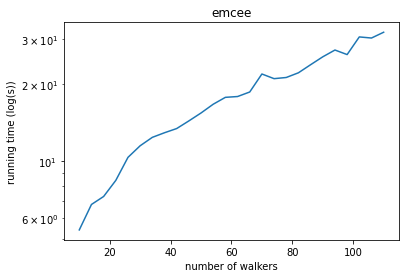

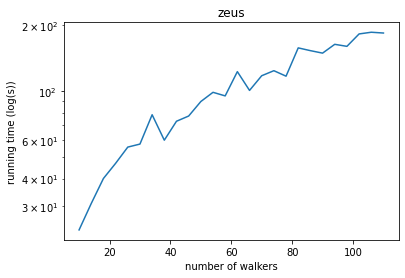

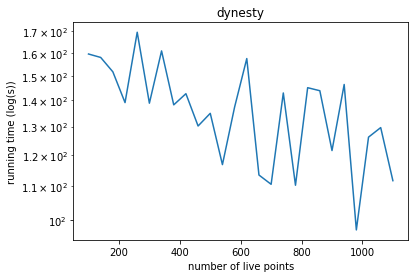

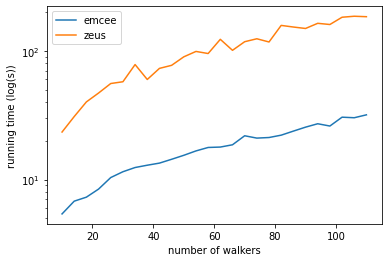

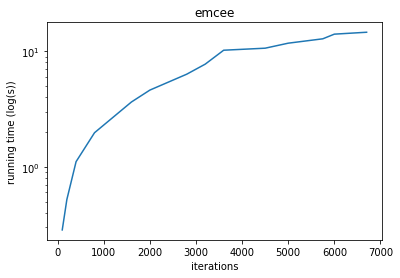

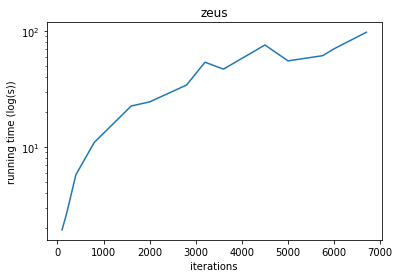

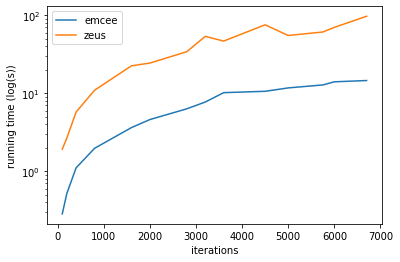

In [22]:
data_file = filename
data = file
nwalk,te,tz,lp,td = np.genfromtxt(data_file, comments='#', usecols=(0,1,2,3,4), unpack=True, delimiter='')
iters,tem,tze = np.genfromtxt(data, comments='#', usecols=(0,1,2), unpack=True, delimiter='')

labels=["emcee","zeus","dynesty"]

plt.figure(1)
plt.plot(nwalk,te)
plt.title(labels[0])
plt.yscale("log")
plt.ylabel("running time (log(s))")
plt.xlabel("number of walkers")

plt.figure(2)
plt.plot(nwalk,tz)
plt.title(labels[1])
plt.yscale("log")
plt.ylabel("running time (log(s))")
plt.xlabel("number of walkers")

plt.figure(3)
plt.plot(lp,td)
plt.title(labels[2])
plt.yscale("log")
plt.ylabel("running time (log(s))")
plt.xlabel("number of live points")

plt.figure(4)
plt.plot(nwalk,te)
plt.plot(nwalk,tz)
plt.yscale("log")
plt.ylabel("running time (log(s))")
plt.xlabel("number of walkers")
plt.legend([labels[0],labels[1]])

plt.figure(5)
plt.plot(iters,tem)
plt.title(labels[0])
plt.yscale("log")
plt.ylabel("running time (log(s))")
plt.xlabel("iterations")

plt.figure(6)
plt.plot(iters,tze)
plt.title(labels[1])
plt.yscale("log")
plt.ylabel("running time (log(s))")
plt.xlabel("iterations")

plt.figure(7)
plt.plot(iters,tem)
plt.plot(iters,tze)
plt.yscale("log")
plt.ylabel("running time (log(s))")
plt.xlabel("iterations")
plt.legend([labels[0],labels[1]])